In [1]:
from argparse import ArgumentParser

import numpy as np
from lal import GreenwichMeanSiderealTime

from gwbench import Network, injections_CBC_params_redshift, M_of_Mc_eta, f_isco_Msolar

In [2]:
np.set_printoptions(linewidth=200)

parser = ArgumentParser()
parser.add_argument('--inj', type = int, help = 'Injection ID in [0,100).', default = 0)
parser.add_argument('--derivs', type = str, help = 'Specify wich differentiation method to use: [num, sym].', default = 'num')

parser.add_argument("-f", required=False)

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, required=False, help=None, metavar=None)

In [3]:
############################################################################
### User Choices
############################################################################

# choose between numeric or symbolic derivatives ['num', 'sym']
derivs = parser.parse_args().derivs

# choose injection id
inj_id = parser.parse_args().inj

# user's choice: waveform to use
# wf_model_name = 'tf2'
#wf_model_name = 'tf2_tidal'
wf_model_name = 'lal_bbh'
# wf_model_name = 'lal_bns'


# the lal_... waveform models are wrappers to call frequency domain waveform from lalsuite
# and thus need further specification of the approximant to use
if   wf_model_name == 'tf2':       wf_other_var_dic = None
elif wf_model_name == 'tf2_tidal': wf_other_var_dic = None
elif wf_model_name == 'lal_bbh':   wf_other_var_dic = {'approximant':'TaylorF2Ecc'}
elif wf_model_name == 'lal_bns':   wf_other_var_dic = {'approximant':'TaylorF2Ecc'}

# user defined waveform model, defined by the files specified in the dictionary (although if 1 is always true and no user defined waveform
# path is taken but if we want to define our own wavefrom then make if 0 )
# only the 'np' one is needed when using numeric derivatives
if 1: user_waveform = None
else:
    wf_model_name    = 'tf2_user'
    wf_other_var_dic = None
    user_waveform   = {'np': '../gwbench/wf_models/tf2_np.py', 'sp':'../gwbench/wf_models/tf2_sp.py'}

In [4]:
# example detector location defined by user (keep it empty if the detector tech is not custom defined )
# user_locs = {'user-loc':{'longitude': 0.0, 'latitude': 0.0, 'arm_azimuth':0.0, 'which_arm':'y', 'shape':'L'}}
user_locs = {}

# example detector psd defined by the user (keep it empty if the detector tech is not custom defined )
# (edit this if using different psd, path can be put as absolute path)(for PSD keep it False but the data files available in noise
# curve folder are all ASD, so keep is_asd=True)
# user_psds = {'user-tec':{'psd_file':'/Users/mlaxman/Documents/gwbench/gwbench/noise_curves/a_plus.txt', 'is_asd':True}}
user_psds = {}


# user's choice: with respect to which parameters to take derivatives for the Fisher analysis
if 'tidal' in wf_model_name or 'bns' in wf_model_name: deriv_symbs_string = 'tc phic'
# else: deriv_symbs_string = 'Mc eta tc phic chi1z chi2z e0'
else: deriv_symbs_string = 'tc phic' 

# user's choice: convert derivatives to cos or log for specific variables
conv_cos = ()
conv_log = ('Mc','eta')

# if symbolic derivatives, take from generate_lambdified_functions.py
# if numeric  derivatives, user's decision
use_rot = 0
# 1 for True, 0 for False

# calculate SNRs, error matrices, and errors only for the network (If 1, will calculate the mentioned values only for network otherwise
# will calculate it for detectors as well as network)
only_net = 1

# number of cores to use for parallelize of the calc_det_responses_derivs
# = None for no parallelization, = 2,3,4,... to allocate N cores (even numbers preferred)
num_cores = None

In [5]:
# options for numeric derivative calculation
if derivs == 'num':
    # user's choice: switch particular partial derivatives to be analytical, options = [DL,tc,phic,ra,dec,psi]
    # otherwise set to None
    ana_deriv_symbs_string = 'tc phic'

    # choose numdifftools parameters for numerical derivatives
    step      = 1e-12
    method    = 'forward'
    order     = 2

    # only relevant for symbolic derivatives
    gen_derivs = None

# options for symbolic derivative calculation
elif derivs == 'sym':

    # user's choice: switch particular partial derivatives to be analytical, options = [DL,tc,phic,ra,dec,psi]
    # otherwise set to None
    ana_deriv_symbs_string = None

    # choose numdifftools parameters for numerical derivatives
    step      = None
    method    = None
    order     = None

    # tell the code to generate symbolic derivatives as needed (turned on this tutorial)
    # the recommendation is to precompute them externally and load them for large-scale runs
    gen_derivs = True


In [6]:
# user's choice to generate injection parameters
if 'tidal' in wf_model_name or 'bns' in wf_model_name:
    mmin      = 0.8
    mmax      = 3
    chi_lo    = -0.05
    chi_hi    = 0.05
else:
    mmin      = 20
    mmax      = 30
    chi_lo    = 0.0
    chi_hi    = 0.0

cosmo_dict = {'zmin':0, 'zmax':0.2, 'sampler':'uniform_comoving_volume_inversion'}
mass_dict  = {'dist':'uniform', 'mmin':mmin, 'mmax':mmax}
# the default waveforms above are non-precessing, hence dim=1, set dim=3 for precessing waveforms like 'IMRPhenomPv2' or 'IMRPhenomPv2_NRTidalv2'
spin_dict  = {'dim':1, 'geom':'cartesian', 'chi_lo':chi_lo, 'chi_hi':chi_hi}

# Flag indicating whether to apply redshift to the mass parameters (redshifted : bool).
redshifted = 1
# Number of injections to generate (default: 10)
num_injs   = 10
# Seed for the random number generator (default: None)
seed       = 29378
file_path  = None

# Generate parameters [(redshifted) masses, spins, luminosity distance, redshift, inclination, right ascension, declination, polarization angle
# for compact binary coalescence (CBC) injections.
injections_data = injections_CBC_params_redshift(cosmo_dict,mass_dict,spin_dict,redshifted,num_injs,seed,file_path)


In [7]:
############################################################################
### injection parameters
############################################################################

inj_params = {
    'Mc'    : 6,
    'e0'    : 0.004,
    'eta'   : 0.0780785246876859,
    'chi1x' : 0.,
    'chi1y' : 0.,
    'chi1z' : 0.5,
    'chi2x' : 0.,
    'chi2y' : 0.,
    'chi2z' : 0.01,
    'DL'    : 200,
    'tc'    : 0.1,
    'phic'  : 0.1,
    'iota'  : 0.,
    'ra'    : 0.,
    'dec'   : 0.,
    'psi'   : 0.,
    'gmst0' : 0.,
    'z'     : 0.04384,
    }


if 'tidal' in wf_model_name or 'bns' in wf_model_name:
    inj_params['lam_t']       = 1
    inj_params['delta_lam_t'] = 5

# print(injections_data[0][99])

print('injections parameter: ', inj_params)
print()

injections parameter:  {'Mc': 6, 'e0': 0.004, 'eta': 0.0780785246876859, 'chi1x': 0.0, 'chi1y': 0.0, 'chi1z': 0.5, 'chi2x': 0.0, 'chi2y': 0.0, 'chi2z': 0.01, 'DL': 200, 'tc': 0.1, 'phic': 0.1, 'iota': 0.0, 'ra': 0.0, 'dec': 0.0, 'psi': 0.0, 'gmst0': 0.0, 'z': 0.04384}



In [8]:
############################################################################
### Network specification
############################################################################
# 'user-tec_user-loc' is for custom define detector and its location
network_spec = ['aLIGO_L']


print('network spec: ', network_spec)
print()

f_lo = 10
# f_hi = f_isco_Msolar(M_of_Mc_eta(inj_params['Mc'],inj_params['eta']))
f_hi = 148.5
df   = 2.**-3
f    = np.arange(f_lo,f_hi+df,df)


print('f_lo:', f_lo, '   f_hi:', f_hi, '   df:', df)
print()

network spec:  ['aLIGO_L']

f_lo: 10    f_hi: 148.5    df: 0.125



In [9]:
############################################################################
### Single Network GW Benchmarking
############################################################################

# initialize Network and do general setup
net = Network(network_spec, logger_name='CSU', logger_level='INFO')
# pass all the needed and optional variables
net.set_net_vars(wf_model_name=wf_model_name, wf_other_var_dic=wf_other_var_dic, user_waveform=user_waveform,
                 f=f, inj_params=inj_params, deriv_symbs_string=deriv_symbs_string,
                 conv_cos=conv_cos, conv_log=conv_log, use_rot=use_rot,
                 user_locs=user_locs, user_psds=user_psds, ana_deriv_symbs_string=ana_deriv_symbs_string)
# start the actual analysis
net.calc_errors(only_net=only_net, derivs=derivs, step=step, method=method, order=order, gen_derivs=gen_derivs, num_cores=num_cores)

### for completeness here are the steps involved, but since gwbench-0.7.4 the code will perform the necessary
### internally as needed
# '''
# net.setup_ant_pat_lpf_psds()
# if derivs == 'num':
#     net.calc_det_responses_derivs_num(step=step, method=method, order=order, num_cores=num_cores)
# elif derivs = 'sym':
#     # generation of lambdified derivatives used to be handles outside and is still recommended for speed reasons
#     # refer to example_script/generate_lambdified_functions.py
#     net.load_det_responses_derivs_sym(gen_derivs=True)
#     net.calc_det_responses_derivs_sym(num_cores=num_cores)
# net.calc_snrs(only_net=only_net)
# net.calc_errors(only_net=only_net)
# '''

2024-06-08 10:18:11,130 - CSU - INFO : PSDs, antenna patterns, and LPFs loaded.
2024-06-08 10:18:11,131 - CSU - INFO : Calculate numeric derivatives of detector responses.
2024-06-08 10:18:11,131 - CSU - INFO :    aLIGO_L
2024-06-08 10:18:11,135 - CSU - INFO : Numeric derivatives of detector responses calculated.
2024-06-08 10:18:11,135 - CSU - INFO : SNRs calculated.
2024-06-08 10:18:11,136 - CSU - INFO : Calculate errors (Fisher & cov matrices).
2024-06-08 10:18:11,136 - CSU - INFO :    aLIGO_L
2024-06-08 10:18:11,139 - CSU - WARNING : calc_errors: tag = network - 90%-credible sky area not calculated due to missing RA or DEC (COS_DEC) errors.
2024-06-08 10:18:11,139 - CSU - INFO : Errors calculated.


In [10]:
############################################################################
### Print results
############################################################################

# net.print_detectors()
# net.print_network()

# print('Fisher analysis done.')

In [11]:
print("SNR:", net.snr)
print("errs:", net.errs)
print("Error in tc:", net.errs['tc'])
# print("Error in e0:", net.errs['e0'])
# print("Error in e0:", (net.errs['e0'])/0.004)

SNR: 25.452794691715543
errs: {'tc': 0.00019655147, 'phic': 0.08446484}
Error in tc: 0.00019655147


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define lower limit, upper limit, and step size for e0 values
Mc_lower = 2
Mc_upper = 20
step_size = 1

# Generate e0 values from lower limit to upper limit with the given step size
Mc_values = np.arange(Mc_lower, Mc_upper+step_size, step_size)

# List to store e0 values and corresponding errors
tc_errors = []

# Loop over the generated e0 values
for Mc_value in Mc_values:
    # Update e0 value in inj_params
    inj_params['Mc'] = Mc_value
    
    # Print current e0 value
    print(f'Computing error for tc = {Mc_value}')
    
    # Initialize Network and do general setup
    net = Network(network_spec, logger_name='CSU', logger_level='INFO')
    # pass all the needed and optional variables
    net.set_net_vars(wf_model_name=wf_model_name, wf_other_var_dic=wf_other_var_dic, user_waveform=user_waveform,
                     f=f, inj_params=inj_params, deriv_symbs_string=deriv_symbs_string,
                     conv_cos=conv_cos, conv_log=conv_log, use_rot=use_rot,
                     user_locs=user_locs, user_psds=user_psds, ana_deriv_symbs_string=ana_deriv_symbs_string)
    # start the actual analysis
    net.calc_errors(only_net=only_net, derivs=derivs, step=step, method=method, order=order, gen_derivs=gen_derivs, num_cores=num_cores)

    # Get error in e0
    tc_error = net.errs['tc']
    
    # Print error in e0
    print("Error in tc:", tc_error)
    
    # Append e0 value and corresponding error to the list
    tc_errors.append([Mc_value, tc_error])

# Print the 2D list of e0 values and errors
# print("e0 values and corresponding errors:")
# for e0_value, e0_error in e0_errors:
#     print(f'e0: {e0_value}, Error: {e0_error}')


2024-06-08 10:18:11,451 - CSU - INFO : PSDs, antenna patterns, and LPFs loaded.
2024-06-08 10:18:11,451 - CSU - INFO : Calculate numeric derivatives of detector responses.
2024-06-08 10:18:11,451 - CSU - INFO :    aLIGO_L
2024-06-08 10:18:11,454 - CSU - INFO : Numeric derivatives of detector responses calculated.
2024-06-08 10:18:11,454 - CSU - INFO : SNRs calculated.
2024-06-08 10:18:11,455 - CSU - INFO : Calculate errors (Fisher & cov matrices).
2024-06-08 10:18:11,455 - CSU - INFO :    aLIGO_L
2024-06-08 10:18:11,457 - CSU - WARNING : calc_errors: tag = network - 90%-credible sky area not calculated due to missing RA or DEC (COS_DEC) errors.
2024-06-08 10:18:11,457 - CSU - INFO : Errors calculated.
2024-06-08 10:18:11,458 - CSU - INFO : PSDs, antenna patterns, and LPFs loaded.
2024-06-08 10:18:11,458 - CSU - INFO : Calculate numeric derivatives of detector responses.
2024-06-08 10:18:11,458 - CSU - INFO :    aLIGO_L
2024-06-08 10:18:11,461 - CSU - INFO : Numeric derivatives of detec

Computing error for tc = 2
Error in tc: 0.0004909953
Computing error for tc = 3
Error in tc: 0.0003502149
Computing error for tc = 4
Error in tc: 0.0002755618
Computing error for tc = 5
Error in tc: 0.00022880244
Computing error for tc = 6
Error in tc: 0.00019655147
Computing error for tc = 7
Error in tc: 0.00017285712
Computing error for tc = 8
Error in tc: 0.00015465383
Computing error for tc = 9
Error in tc: 0.00014019533
Computing error for tc = 10
Error in tc: 0.00012841102
Computing error for tc = 11
Error in tc: 0.00011860648
Computing error for tc = 12
Error in tc: 0.00011031078
Computing error for tc = 13
Error in tc: 0.00010319283
Computing error for tc = 14
Error in tc: 9.701278e-05
Computing error for tc = 15
Error in tc: 9.159243e-05
Computing error for tc = 16
Error in tc: 8.679653e-05
Computing error for tc = 17
Error in tc: 8.252044e-05
Computing error for tc = 18
Error in tc: 7.868197e-05
Computing error for tc = 19
Error in tc: 7.5215554e-05
Computing error for tc = 2

In [13]:
np.savetxt('tcphic_favata_fig1_BBH_fhi148p5_dfm2p14_stepm12.txt', tc_errors, fmt='%f %f')

In [14]:
print(tc_errors)

[[2, 0.0004909953], [3, 0.0003502149], [4, 0.0002755618], [5, 0.00022880244], [6, 0.00019655147], [7, 0.00017285712], [8, 0.00015465383], [9, 0.00014019533], [10, 0.00012841102], [11, 0.00011860648], [12, 0.00011031078], [13, 0.00010319283], [14, 9.701278e-05], [15, 9.159243e-05], [16, 8.679653e-05], [17, 8.252044e-05], [18, 7.868197e-05], [19, 7.5215554e-05], [20, 7.206825e-05]]


In [15]:
import numpy as np
import matplotlib.pylab as plt

In [16]:
tc, tcerror = np.loadtxt("/Users/mlaxman/Documents/gwbench/example_scripts/tcphic_favata_fig1_BBH_fhi148p5_dfm2p14_stepm12.txt", unpack=True)

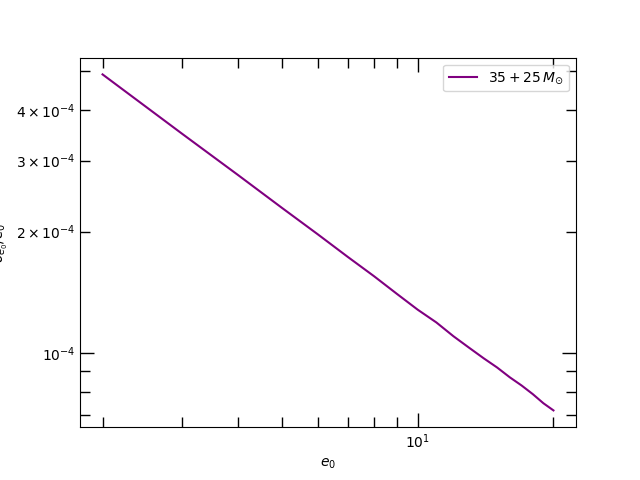

In [17]:
%matplotlib widget

plt.xscale("log")
plt.yscale("log")

plt.xlabel('$e_{0}$')
plt.ylabel('$\sigma_{e_{0}}/e_{0}$')

# plt.xlim([0.001,0.3])
# plt.ylim([1e-3,10])

plt.plot(tc, tcerror, color='purple', linestyle='-', label='$35+25\,M_{\odot}$')

# Adding text annotations
# plt.text(1e-1, 1e-1, '25 + 15 M⊙\nSNR=26.8', fontsize=12, color='black')
# plt.text(3e-2, 2e-1, '15 + 10 M⊙\nSNR=18.6', fontsize=12, color='navy')
# plt.text(1.2e-2, 3e-2, '35 + 25 M⊙\nSNR=37.2', fontsize=12, color='blue')
# plt.text(1.5e-2, 5e-2, '10 + 5 M⊙\nSNR=11.8', fontsize=12, color='purple')
# plt.text(3e-3, 3e-1, 'NS/BH 15 + 1.4 M⊙\n200 Mpc, SNR=17.9', fontsize=12, color='brown')
# plt.text(6e-3, 5e-1, 'NS/NS 1.4 + 1.25 M⊙\n100 Mpc, SNR=13.9', fontsize=12, color='orange')
# plt.text(2e-3, 1.5e-2, 'BH/BHs, 500 Mpc', fontsize=12, color='purple')

plt.tick_params(width=1, color="black", direction="in", which="minor", right="true", length=7.5)
plt.tick_params(width=1, color="black", direction="in", which="major", right="true", length=10)

plt.tick_params(width=1, color="black", direction="in", which="minor", top="true", length=7.5)
plt.tick_params(width=1, color="black", direction="in", which="major", top="true", length=10)

plt.legend(loc='best', prop={"size":10})

# plt.savefig("favata_2022_fig1", dpi=500, bbox_inches='tight')
plt.show()